# BME 342 - Final Project

*Victor Ibañez & Lasse Meyer, Bodenmiller Lab, 15.11.2024*

This script can be used as a template for the final project of block course **BME 342, Deep Learning in Biomedicine**. 

**It contains:**
- *Information, guidelines*
- *Imports of many useful packages*
- *Some functions which can be used for preprocessing, image loading and image visualization.*
- *A potential structure for the project*

**Here is a guideline for the project that can be (but not has to be!) considered and may be helpful:**

Preliminary EDA & data cleaning:
-	Read about the data type
-	Investigate data & plot class distribution

Preprocessing:
-	Normalization 
-	Transformation
-	Data augmentation
-	Up-/downsampling
-	Channel reduction
-	Image Resizing
-	Label preparation

Model architecture:
-	NNs, CNNs, Transformers, ABMILs, etc.

Training framework:
-	Train-/test split
-	Different optimizers
-	Different loss functions
-	Different metrics
-	Cross validation
-	Early Stopping
-	Learning rate scheduler

Data management:
-	Generator from file path or CPU
-	Disable GPU (if not enough RAM on GPU)

Training log & Results visualization:
-	Plot training and validation process
-	Log training history
-	Plot Confusion matrix

**Keep in mind when working with jupyter notebooks:**
- Come up with a clear and concise structure of your project
- Comment your working steps by changing the cell to Markdown
- Use blocks for single code logic (at least try to)
- Include plots & other visualizations; this is the advantage of using notebooks!

But most importantly... happy coding! &#128512;

### Initialize Notebook

In [1]:
import helper as hp 
hp.initialize_notebook() # initialize with GPU enabled  
# hp.initialize_notebook(False) # to disable GPU 

2024-12-12 16:26:26.450843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 16:26:26.465335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 16:26:26.469843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 16:26:26.480565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU enabled. Checking for available GPUs...
1 Physical GPUs, 1 Logical GPUs

Verifying TensorFlow and PyTorch CUDA setup...
TensorFlow version: 2.17.0
Built with CUDA: True
Num GPUs Available: 1

Keras version: 3.6.0

End checks and initialization.


I0000 00:00:1734020788.373796  590817 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734020788.413155  590817 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734020788.418720  590817 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734020788.424812  590817 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [2]:
# Import standard libraries
import os
import sys
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import DL libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import layers, models, Model, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import ML libraries
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Import image libraries
from skimage import transform
import tifffile as tiff

# Appends current working dir
current_path = os.getcwd()
sys.path.append(current_path)

# Import custom preprocessing class
from imc_preprocessing import IMCPreprocessor

In [3]:
# Preprocessing (if needed)
def preprocessing(image, transpose=True, normalize=True) -> np.ndarray:
    if transpose:
        return np.transpose(image, (1, 2, 0))
    if normalize:
        return IMCPreprocessor.normalize_multichannel_image(image)

In [4]:
# Load images
def load_image(image_path) -> np.ndarray:
    image = tiff.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return image


# Define a function to create a list of images from files within a folder 
def image_list(image_dir):
    # List all files in the directory
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]  
    # Initialize a list to store the images
    images = []
    # Loop through each file and read the image
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        image = load_image(image_path)
        images.append(image)        
    return images 


In [5]:

# # Extract channel information
# panel_df = pd.read_csv('panel.csv')
# channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

# # change 'your_image_array' to your actual array name that contains the images
# img_nb = 1
# channel_to_display = ['Yb173'] # choose a channel to display
# plt.imshow(IMCPreprocessor.drop_channels(your_image_array[img_nb], channel_to_display, list(channel_names.values()))[0], cmap='gray')
# plt.title(f"{channel_to_display[0]} - channel")
# plt.axis('off')
# plt.show()


## Load & preprocess images

Get Folder Directory

In [6]:
folder_directory = os.getcwd()
print(folder_directory)

/home/jupyter-luvogt/Final_Project_LR/code


Inspect Folder Elements of IMC_images

In [7]:
images_dir = '/home/jupyter-luvogt/Final_Project_LR/IMC_images' 
metadata_dir = '/home/jupyter-luvogt/Final_Project_LR/metadata.csv' 
panel_dir = '/home/jupyter-luvogt/Final_Project_LR/panel.csv' 
os.listdir(folder_directory)[:5] # Get first five images

['__pycache__',
 'Project.ipynb',
 'Data_Preparation.ipynb',
 'helper.py',
 'imc_preprocessing.py']

Load images and labels

In [8]:
# Load images
images = image_list(images_dir)
# load labels
# PDL1
metadata = pd.read_csv(metadata_dir)
PDL1_score = metadata["PDL1_score"]


How many images & Shapes

In [9]:
# length of images in the list
print("Length of list with images:", len(images))
# Length of PDL1_score labels
print("Length of list with images:", len(PDL1_score))
# Shape of the individual images
print("Shape of the 1st image:", images[0].shape) # 46 Channels, 224 (x) * 224 (y) pixels
# Data type 
print("Data type of 1st image:", images[0].dtype)

Length of list with images: 984
Length of list with images: 984
Shape of the 1st image: (46, 224, 224)
Data type of 1st image: float32


Need to preprocess the image in order to used drop_channels method! Transpose the array to get correct shape

shape (channels, x, y) --> (x, y, channels)

Also normalizing

Plot 1st image with the 42 channels

In [10]:
first_image = images[0]
first_image_transposed = preprocessing(first_image, transpose=True, normalize=False) 
first_image_transposed_normalized = preprocessing(first_image_transposed, transpose=False, normalize=True) 

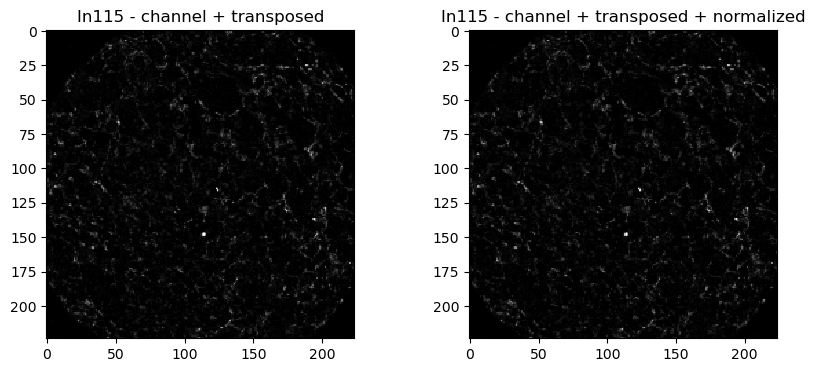

In [11]:
# Extract channel information
panel_df = pd.read_csv(panel_dir)
channel_names = dict(zip(panel_df['clean_target'].to_list(), panel_df['channel'].to_list()))

# change 'your_image_array' to your actual array name that contains the images
# img_nb = 0
channel_to_display = ['In115'] # choose a channel to display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(IMCPreprocessor.drop_channels(first_image_transposed, channel_to_display, list(channel_names.values()))[0], interpolation = "none", cmap='grey')
ax1.set_title(f"{channel_to_display[0]} - channel + transposed")
ax1.axis("on")
ax2.imshow(IMCPreprocessor.drop_channels(first_image_transposed_normalized, channel_to_display, list(channel_names.values()))[0], interpolation = "none", cmap='grey')
ax2.set_title(f"{channel_to_display[0]} - channel + transposed + normalized")
ax2.axis("on")
plt.show()

In [12]:
print(np.mean(first_image_transposed))
print(np.mean(first_image_transposed_normalized))

print(np.std(first_image_transposed))
print(np.std(first_image_transposed_normalized))

print(np.max(first_image_transposed))
print(np.max(first_image_transposed_normalized))

print(np.min(first_image_transposed))
print(np.min(first_image_transposed_normalized))

1.9663248
0.045792855
7.926831
0.10775336
155.44931
1.0
0.0
0.0


Plotting all 46 channels for first image transpoed and normalized

Channels Xe131 and Xe134 seem very noisy --> investigate for all images 

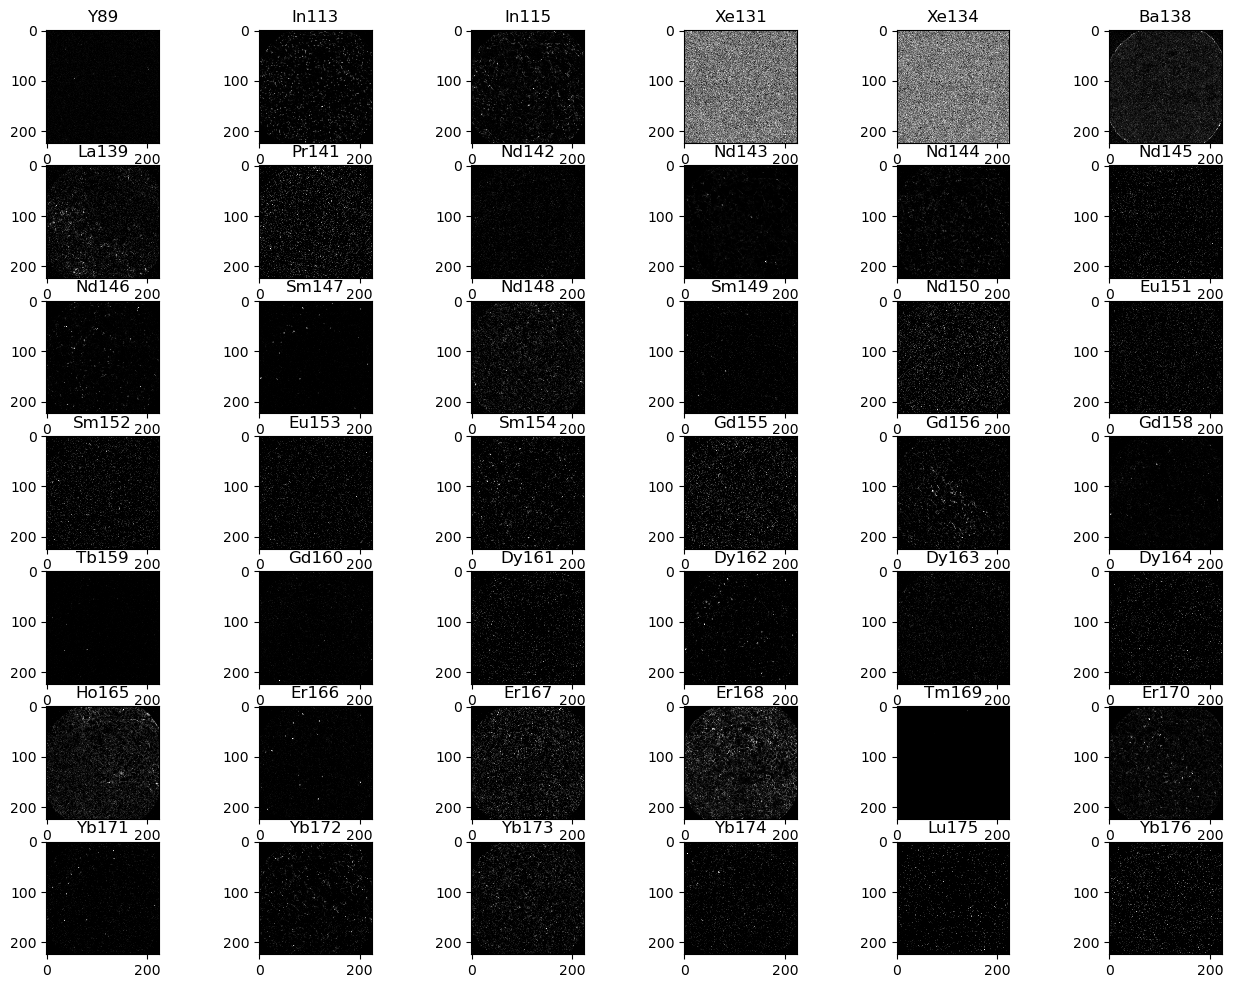

In [13]:

fig=plt.figure(figsize=(16, 12))
columns = 6
rows = 7
# first_image = images[0]
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(first_image[i-1], interpolation = "none", cmap = "grey")
    plt.title(list(channel_names.values())[i-1])
plt.show()

In [14]:
# Preprocessing all the images: Transpose
images_preproc = [preprocessing(i, transpose = True, normalize = False) for i in images]
images_preproc = [preprocessing(i, transpose = False, normalize = True) for i in images_preproc]

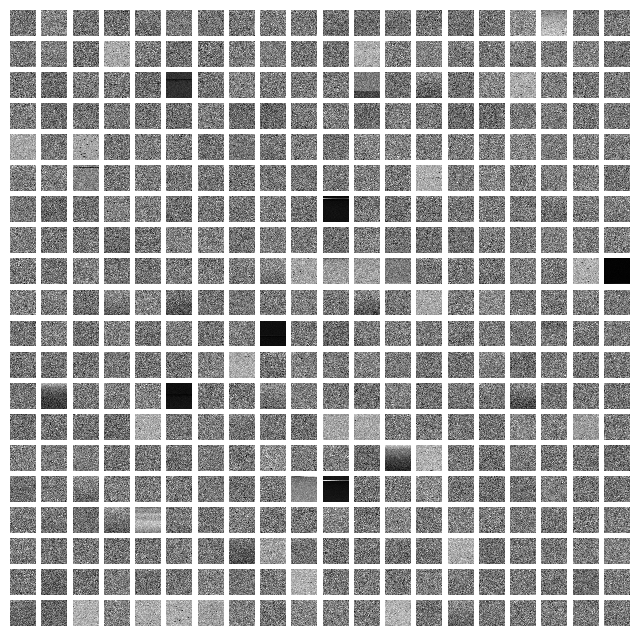

In [15]:

channel_to_display = ['Xe131', "Xe134"] # choose a channel to display
fig=plt.figure(figsize=(8,8))
columns = 20
rows = 20
# first_image = images[0]
# Display Channel Xe131 for first 400 images
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(IMCPreprocessor.drop_channels(images_preproc[i-1], [channel_to_display[0]], list(channel_names.values()))[0], interpolation = "none", cmap='grey')
    plt.axis("off")
plt.show()

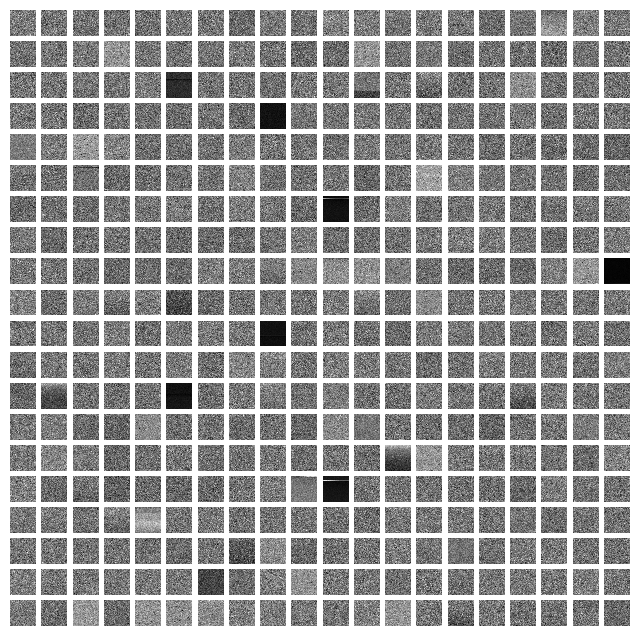

In [16]:
# Plot Xe134 Channel for first 400 images
fig=plt.figure(figsize=(8,8))
columns = 20
rows = 20
for i in range(1, columns*rows + 1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(IMCPreprocessor.drop_channels(images_preproc[i-1], [channel_to_display[1]], list(channel_names.values()))[0], interpolation = "none", cmap='grey')
    plt.axis("off")
plt.show()

## EDA & Data Cleaning

For both Xe131 and Xe134, the whole data sets seems to be very noisy --> filter it out for the time being


In [17]:
channel_names_new = [x for x in list(channel_names.values()) if x not in ["Xe131", "Xe134"]]

In [18]:
# Drop Channels: Xe131 and Xe134
images_preproc_drop = IMCPreprocessor.drop_channels(images_preproc[i-1], channel_names_new, list(channel_names.values()))[0]
channels_preproc_drop = channel_names_new

In [20]:
images_preproc_drop.shape # Only 44 channel now --> Xe131 and Xe134 successfully dropped

(224, 224, 44)

##### EDA: Assess PDL1 Distribution

Stratified Shuffle is necessary to attain a balanced setting! 

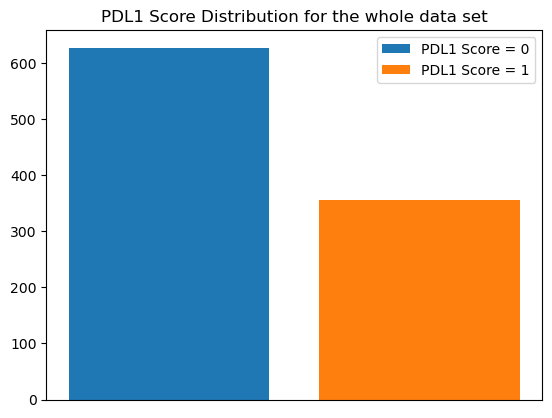

In [52]:
PDL1_1 = PDL1_score[np.where(PDL1_score == 0)[0]].shape[0]
PDL1_2 = PDL1_score[np.where(PDL1_score == 1)[0]].shape[0]
n = PDL1_1 + PDL1_2
plt.bar(0, PDL1_1, label = 'PDL1 Score = 0')
plt.bar(1, PDL1_2, label = 'PDL1 Score = 1')
plt.legend()
plt.title("PDL1 Score Distribution for the whole data set")
plt.gca().get_xaxis().set_visible(False)
plt.show()


#### Baseline Accuracy


In [73]:
baseline_accuracy = np.max([PDL1_1/n, PDL1_2/n])
print("Baseline accuracy is {:.2}%".format(baseline_accuracy))

Baseline accuracy is 0.64%


## Load & Filter dataframe